<h1>Composite Distributions</h1><br>
This script will combine two seperate distributions, using a third distribution to perform the ordering. Two of these distributions should already be defined (RHS and ordering) and saved in files to be loaded. The RHS distribution can come from any of the saved distributions and more can be generated using the three technologies above. The ordering currently can only be generated in 'HMM Gaussian Distributions.ipynb'.The LHS distribution is auto generated using the raw data as input.

# Licence
BSD 3-Clause License

Copyright (c) 2020, Cyber Security Research Centre Limited
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.



<h2>Setup</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from HelperFunctions import MultiHist

In [2]:
#convenience variables
sec = 1000000000 #ns
split_time = 0.00025 #the location in seconds where the split occurs

#tweakable parameters
data_csv = 'data.csv' #the raw data
c_id = 4 #which client in the data the distributions refer to
RHS_max_val = 100 #remove any interarrival times greater than this value in the RHS. For cleaning the data (outliers). When c_id=4 this should only remove 3 points

#files
RHS_dist_file = f"HMM_25_RHS_dist_c{c_id}.npz" #load
ordering_dist_file = f"HMM_25_ordering_dist_c{c_id}.npz" #load
combined_dist_file = f"composite_dist_c{c_id}.npz" #save
dist_folder = "saved_dist"

<h2>Data Loading</h2>

In [3]:
#prepend the folder location
RHS_dist_file = os.path.join(dist_folder, RHS_dist_file)
ordering_dist_file = os.path.join(dist_folder, ordering_dist_file)
combined_dist_file = os.path.join(dist_folder, combined_dist_file)

#load the raw data
X = pd.read_csv(data_csv)
orig_times = X[(X.client_id == c_id)].time.apply(lambda x:x/sec) #convert to seconds
orig_times.sort_values
orig_delta = np.ediff1d(orig_times)
orig_delta = orig_delta[orig_delta > 0] #remove duplicate points
delta_mean = np.mean(orig_delta)
delta_std = np.std(orig_delta)

print(f"Orig mean: {delta_mean}, orig std: {delta_std}")
print(f"Orig Max Time: {orig_times.max()} seconds")
print(f"Orig Data Points: {len(orig_times)}")

#load the RHS dist
f = np.load(RHS_dist_file, allow_pickle=True)
RHS_delta = f["deltas"]
RHS_delta = RHS_delta#[RHS_delta < RHS_max_val]

#load the ordering dist
f = np.load(ordering_dist_file, allow_pickle=True)
ordering_dist = f["dist"]

#generate the LHS lognorm dist
n = np.random.lognormal(mean=np.mean(np.log(orig_delta[orig_delta < split_time])), sigma=np.std(np.log(orig_delta[orig_delta < split_time])), size=orig_delta[orig_delta < split_time].size*3)
LHS_delta = n[n > 0] #ensure no 0 or negative values

Orig mean: 0.8975650506628737, orig std: 7.825000598875937
Orig Max Time: 244608.309583663 seconds
Orig Data Points: 284553


<h2>Forming the Composite Distribution</h2>

In [4]:
#A function for zipping two arrays (d0, d1) given a third array defining the order of distributions to pull from.
#will zip until any of the input arrays run out of points
#d0 - array of interarrivals (typically from the LHS distribution)
#d1 - array of interarrivals (typically from the RHS distribution)
#dist_sequence - array of 0 or 1. 0 pulls from d0, 1 pulls from d1
def zip_distribution(d0, d1, dist_sequence):
    d0_i = 0
    d1_i = 0
    dist_sequence_i = 0
    new_dist = []
    while (dist_sequence_i < dist_sequence.size):
        if (d0_i >= d0.size):
            print(f"Breaking early due to limited d0")
            break
        if (d1_i >= d1.size):
            print(f"Breaking early due to limited d1")
            break
        
        if (dist_sequence[dist_sequence_i] == 0):
            new_dist.append(d0[d0_i])
            d0_i += 1
        elif (dist_sequence[dist_sequence_i] == 1):
            new_dist.append(d1[d1_i])
            d1_i += 1
        else:
            #wtf
            pass
        dist_sequence_i += 1
        
    return np.array(new_dist)

new_delta = zip_distribution(LHS_delta, RHS_delta, ordering_dist)
print(f"Zipped Points: {new_delta.size}")
np.savez(combined_dist_file, deltas=new_delta) #save it

Zipped Points: 270000


<h2>Evaluation</h2><br>
Better combination distributions will match the shape of the original distribution closer.<br>

Note: the actual time period covered by each histogram may not excatly match the specified time period. In some cases it will be shorter since there was not enough data to fill the entire time period and thus the timeperiod has been auto-shrunk to fill the graph.

<h3>Interarrival Graphs</h3>

Mean_new:	0.9166586302748556 sec, 	Std_new:		8.686941032837108
mean_orig:	0.8975650506628737 sec, 	Std_orig (no outliers):	2.9225370252400786
						Std_orig (outliers):	7.825000598875937


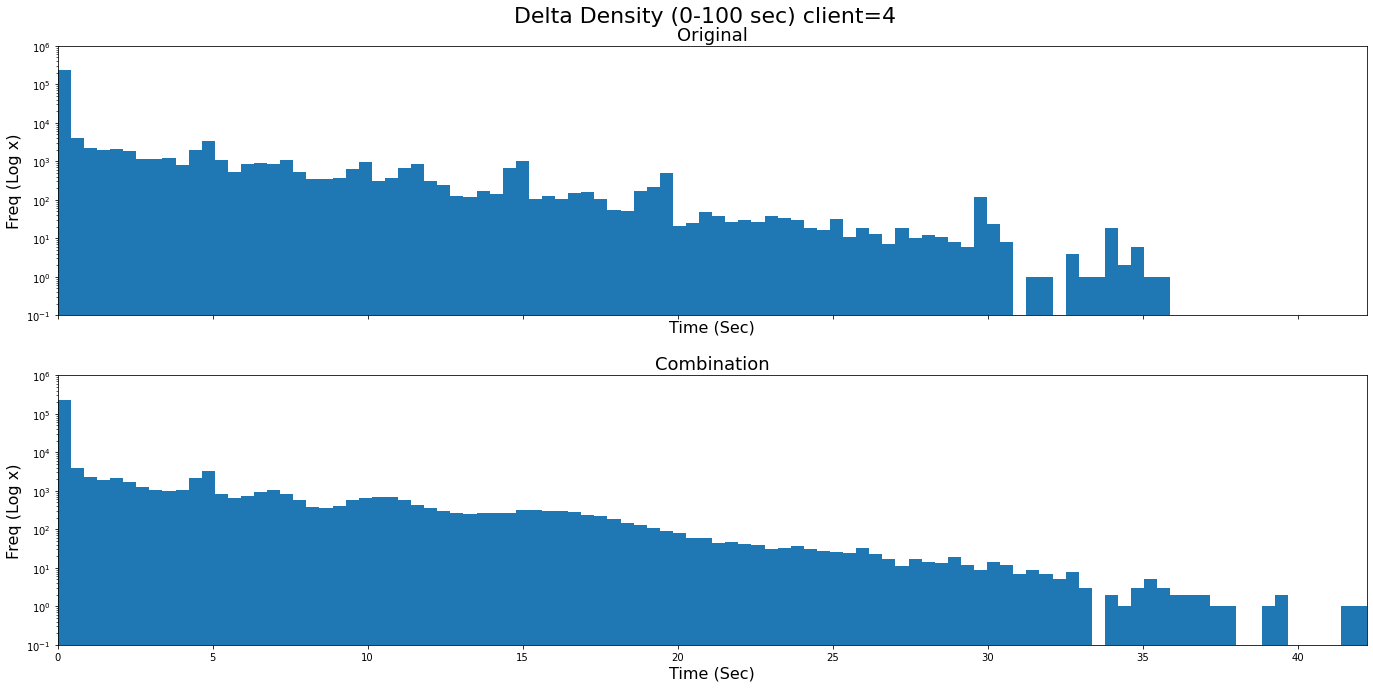

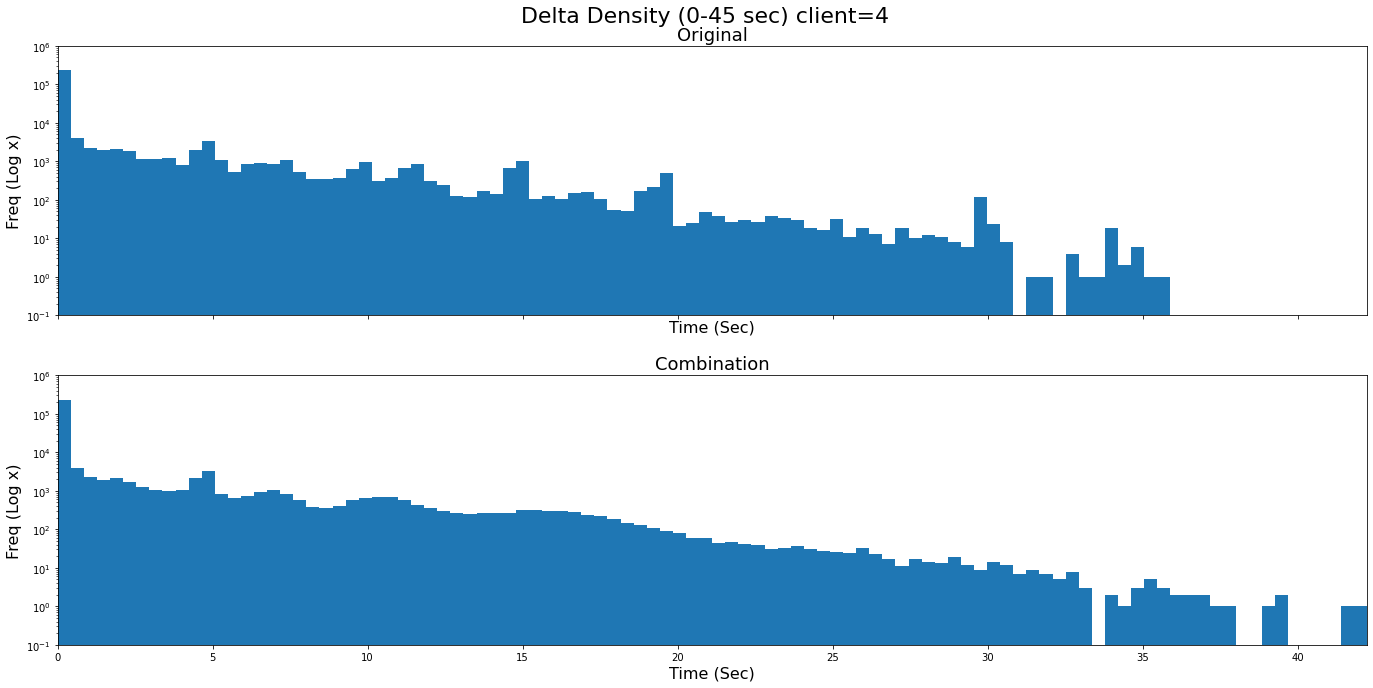

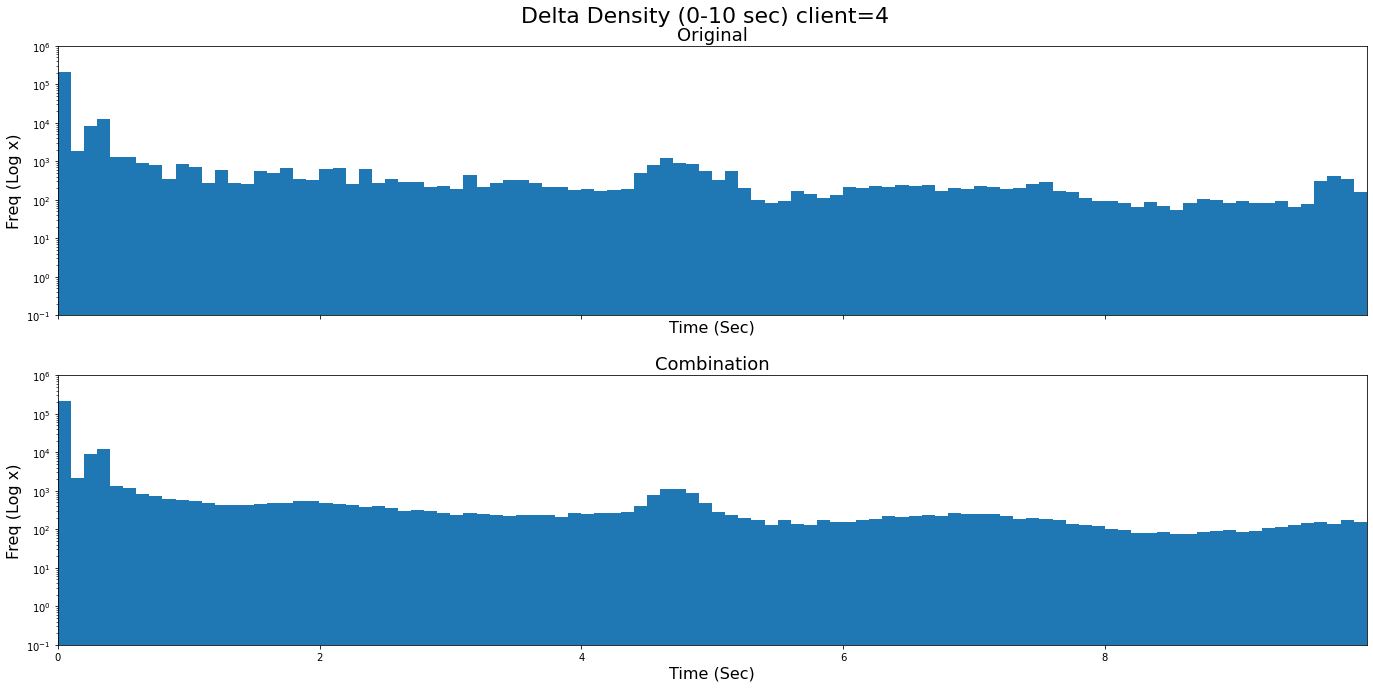

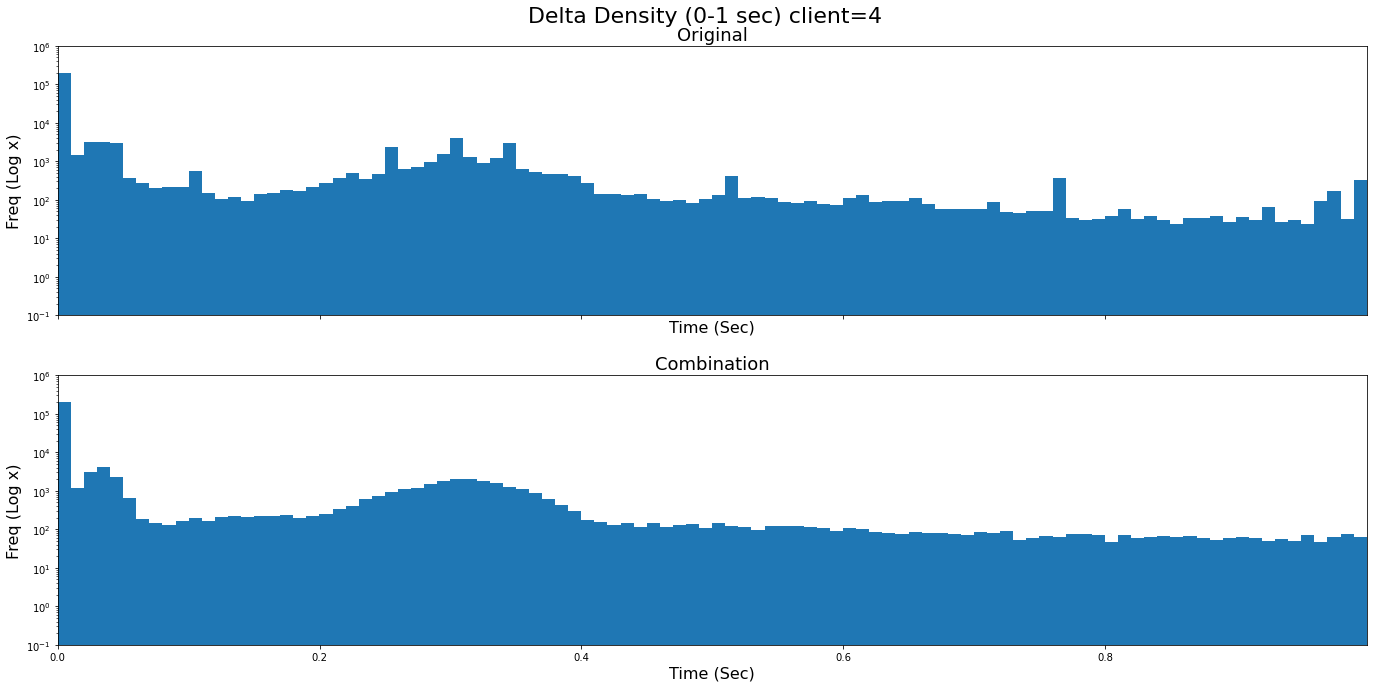

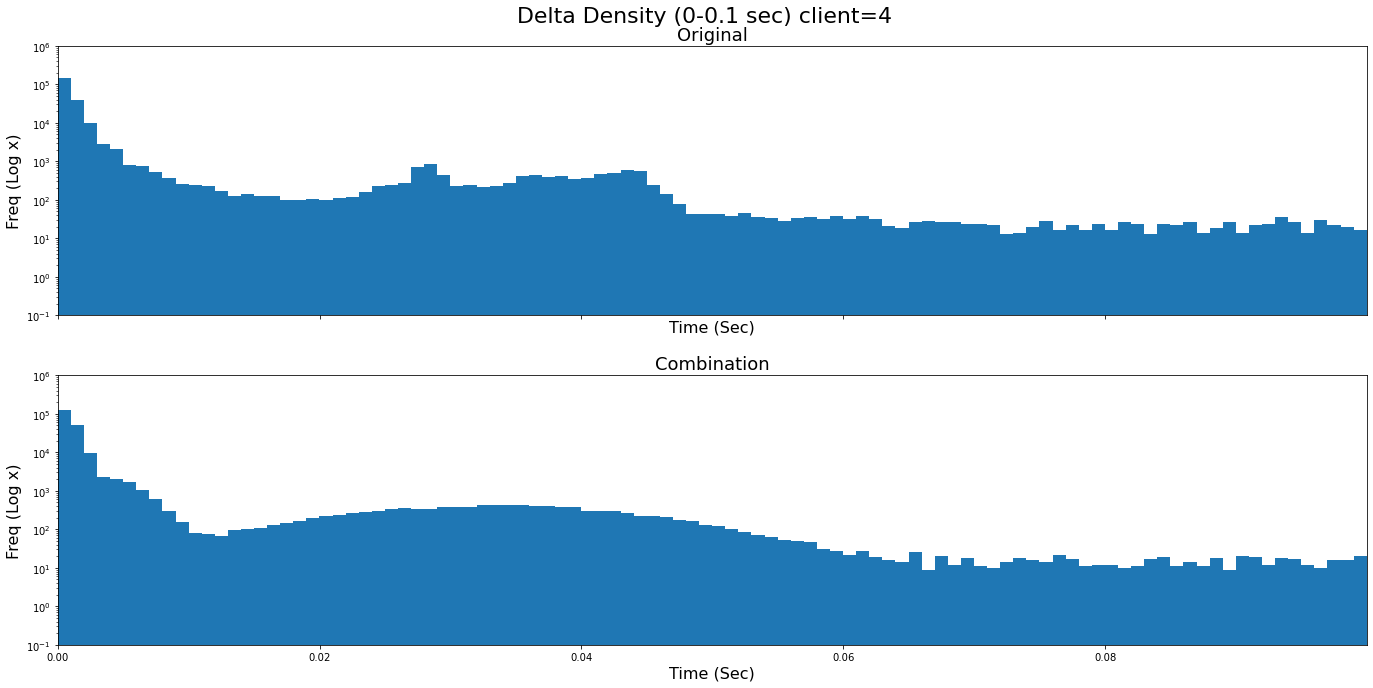

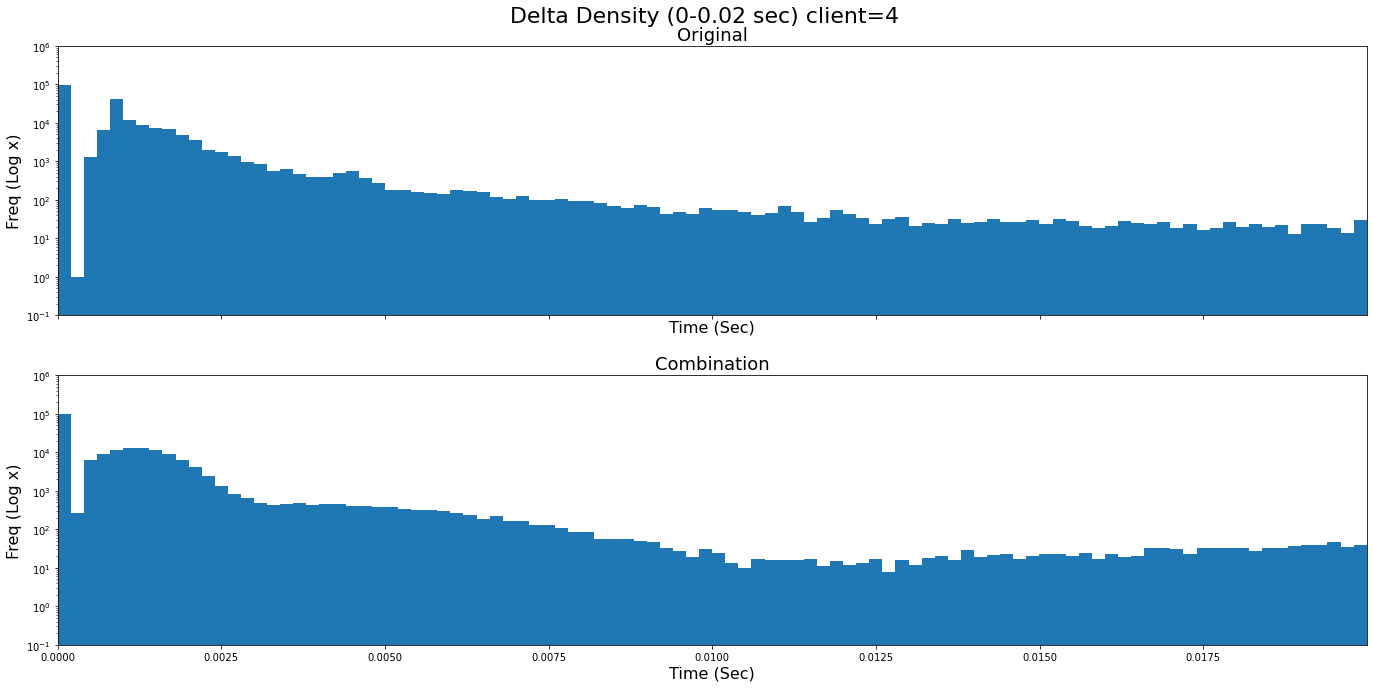

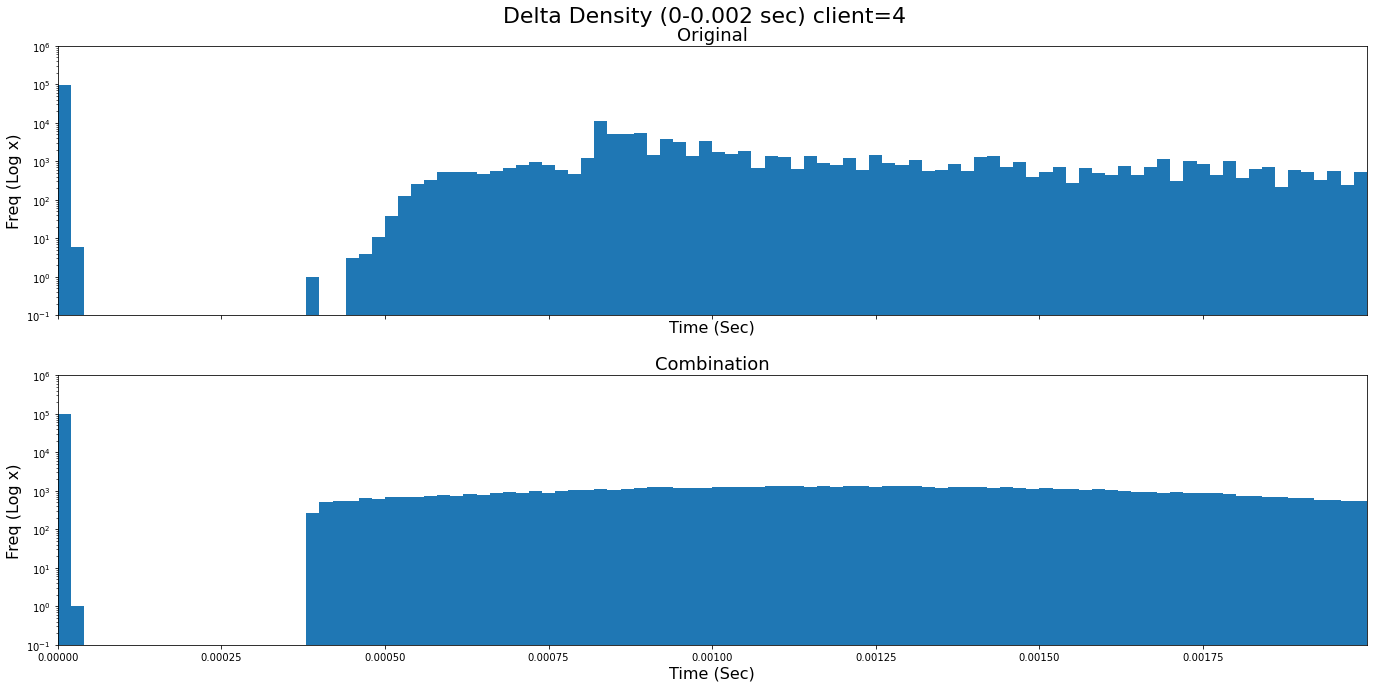

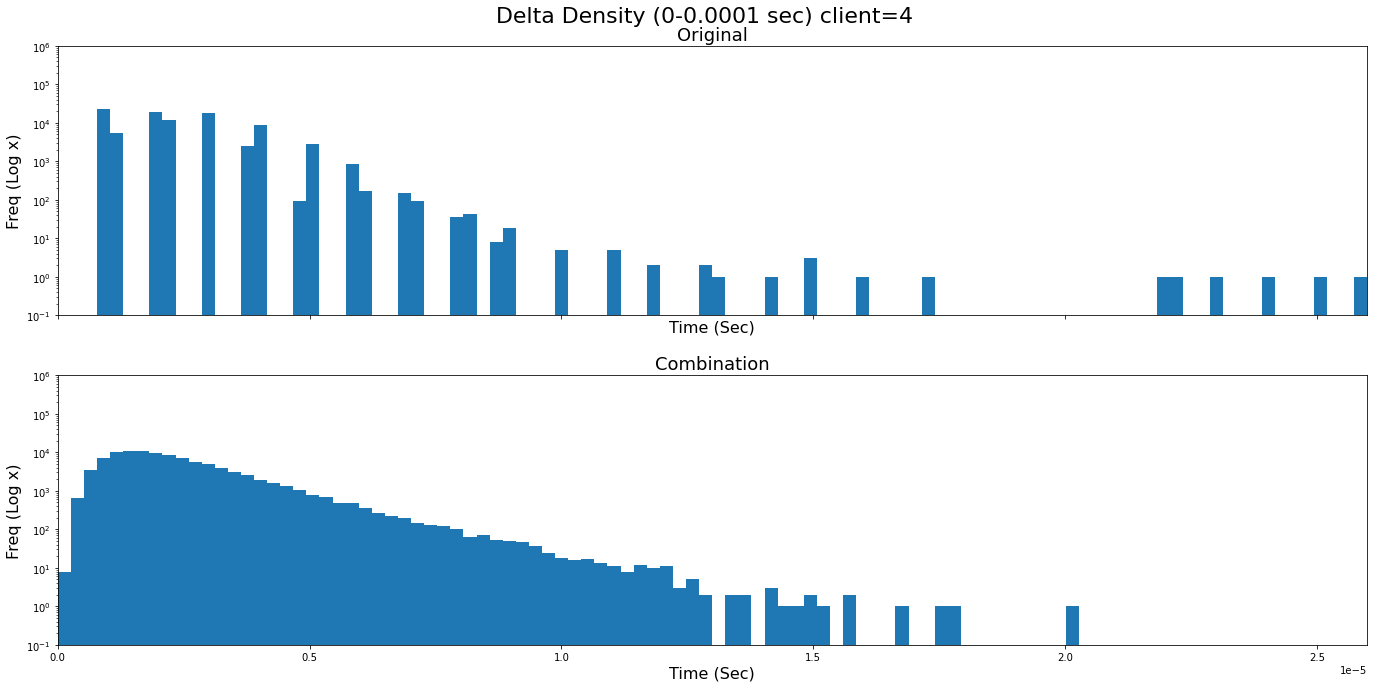

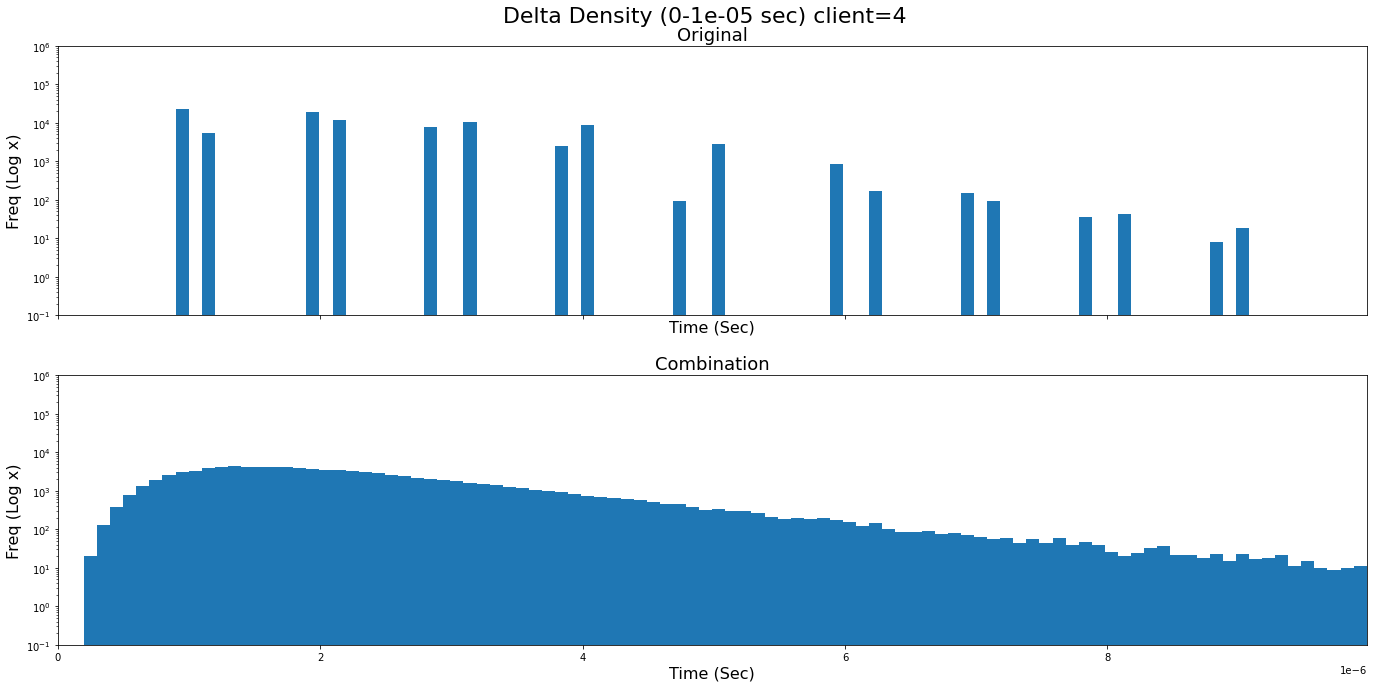

In [5]:
print(f"Mean_new:\t{np.mean(new_delta)} sec, \tStd_new:\t\t{np.std(new_delta)}")
print(f"mean_orig:\t{np.mean(orig_delta)} sec, \tStd_orig (no outliers):\t{np.std(orig_delta[orig_delta < RHS_max_val])}\n\t\t\t\t\t\tStd_orig (outliers):\t{np.std(orig_delta)}") #dont consider outliers

#generate comparison histograms viewing different time scales for both the original and new distributions
#considers interarrival times of both distributions
timescale=[100,45,10,1,0.1,0.02, 0.002, 0.0001, 0.00001] #timescales to consider in seconds
for i in timescale:
    MultiHist([orig_delta[orig_delta<i], new_delta[new_delta<i]], title=f'Delta Density (0-{i} sec) client={c_id}', subtitles=['Original', 'Combination'], bins=100, y_max=1000000)

<h3>Timeline Graph</h3><br>
The purpose of this is to ensure no 'funny business' is going on. Both graphs should be of similar intensity over time and appear to contain similar amounts of random noise and terminate at approximately the same time.

New_max_time:	 247497.8301742107 sec
Orig_max_time:	 244608.309583663 sec


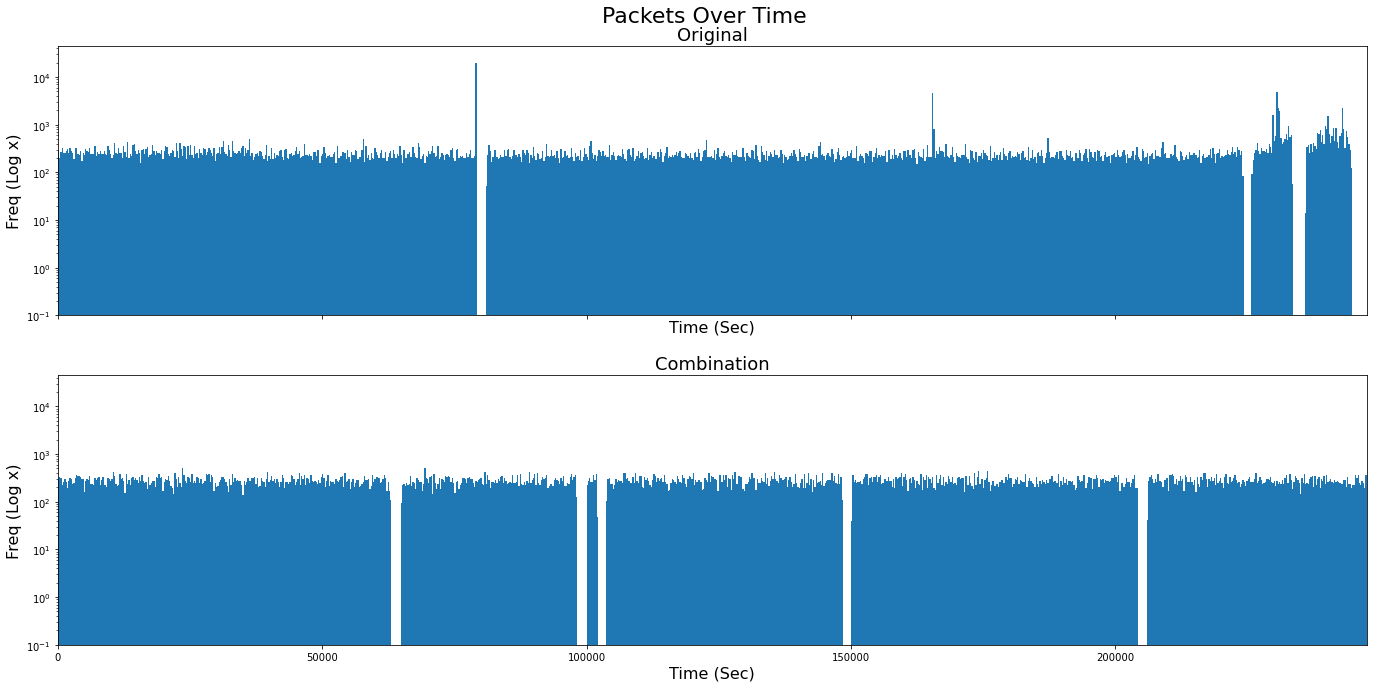

In [6]:
#density over time
new_times = np.cumsum(new_delta)
print(f"New_max_time:\t {np.max(new_times)} sec")
print(f"Orig_max_time:\t {np.max(orig_times)} sec")

MultiHist([orig_times, new_times], title=f'Packets Over Time', subtitles=['Original', 'Combination'], bins=1000, y_max=45000)